In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter

# constants
Win_len = 5


# find adjs and nonadjs for each word in data

data = pd.read_csv('ferdosi.txt', encoding='utf-8',header = None)

data[0] = data[0].str[:-1]
data[1] = data[1].str[1:]

column01 = list(data[0].str.split(' ', expand=True).stack())
column02 = list(data[1].str.split(' ', expand=True).stack())

all_words = column01 + column02


Counts  = Counter(all_words)
Counts  = Counts.most_common()
rep_num = list()
words   = list()
rep_num = [w[1] for w in Counts]
words   = [w[0] for w in Counts]
words   = np.array(words)

dist_adj = int((Win_len-1)/2)


adj_word_list = list()
adj_idx_list  = list()


for i, mes01 in enumerate(data[0]):
    mes02 = data[1][i]
    
    words_in_mes01 = mes01.split(' ')
    words_in_mes02 = mes02.split(' ')
    
    for j in range(len(words_in_mes01)):
        
        center_indx = np.where(words == words_in_mes01[j])[0].astype(np.int32)
        
        counter = 0
        for k in range(1,j+1):
            
            if counter == dist_adj:
                break
            counter = counter + 1 
            adj_word_list.append([words_in_mes01[j],words_in_mes01[j-k]])
            
            adj_idx = np.where(words == words_in_mes01[j-k])[0].astype(np.int32)
            adj_idx_list.append([center_indx,adj_idx])
            
        counter = 0
        for k in range(j,len(words_in_mes01)-1):
            
            
            if counter == dist_adj:
                break
            counter = counter + 1
            adj_word_list.append([words_in_mes01[j],words_in_mes01[k+1]])    
            
            adj_idx = np.where(words == words_in_mes01[k+1])[0].astype(np.int32)
            adj_idx_list.append([center_indx,adj_idx])
            
            
    for j in range(len(words_in_mes02)):
        
        center_indx = np.where(words == words_in_mes02[j])[0].astype(np.int32)
        
        counter = 0
        for k in range(1,j+1):
            
            counter = counter + 1 
            if counter == dist_adj:
                break
            adj_word_list.append([words_in_mes02[j],words_in_mes02[j-k]])
            
            adj_idx = np.where(words == words_in_mes02[j-k])[0].astype(np.int32)
            adj_idx_list.append([center_indx,adj_idx])
            
        counter = 0
        for k in range(j,len(words_in_mes02)-1):
            
            counter = counter + 1
            if counter == dist_adj:
                break
            adj_word_list.append([words_in_mes02[j],words_in_mes02[k+1]])    
            
            adj_idx = np.where(words == words_in_mes02[k+1])[0].astype(np.int32)
            adj_idx_list.append([center_indx,adj_idx])

adj_mat = np.zeros(shape=(len(words),len(words)), dtype=np.int32)
for i in range(len(adj_word_list)):
    idx1, idx2 = adj_idx_list[i]
    adj_mat[idx1,idx2] += 1
    
nonadj = list()
adj    = list()
for i in range(len(words)):
    adj.append(np.where(adj_mat[i,:] != 0)[0].astype(np.int32))
    nonadj.append(np.where(adj_mat[i,:] == 0)[0].astype(np.int32))


In [20]:
# constant

Hidden_dim = 25
num_neg = 100
data_in_batch = 256
itr_num = 2000
lr_base = 1e-2
lr_decay = 0.999
lr_floor = 1e-4
lr = lr_base

P = np.array(rep_num)**(3/4)/np.sum(np.array(rep_num)**(3/4))

In [21]:
tf.reset_default_graph()

####################################################################
############################# input ################################
####################################################################

# this is the center word which is going to be embedded
input_word = tf.placeholder(shape=(None,),dtype=tf.int32)
# one adj and multiple nonadjs for negative sampling
adj_word_idx = tf.placeholder(shape=(None,),dtype=tf.int32)
nonadj_words_idx = tf.placeholder(shape=(None,num_neg),dtype=tf.int32)



####################################################################
############################# weights ##############################
####################################################################

# Weight Matrix (Transformation)
W1 = tf.get_variable('W1', shape = [Hidden_dim, NumWords],
                     initializer=tf.initializers.truncated_normal(stddev = 0.1, seed = 0), dtype=tf.float32)
W2 = tf.get_variable('W2', shape=(Hidden_dim, NumWords),
                     initializer=tf.initializers.truncated_normal(stddev = 0.1, seed = 0),dtype=tf.float32) 

embedded_input   = tf.gather(W1, indices=input_word, axis=1)
embedded_adj     = tf.gather(W2, indices=adj_word_idx, axis=1)
embedded_nonadjs = tf.reshape(tf.gather(W2, indices=tf.reshape(nonadj_words_idx, [-1]), axis=1), shape=[Hidden_dim,-1,num_neg])


####################################################################
############################# loss #################################
####################################################################

# here we repeated input so we could multipy it to all negative samples

temp = tf.tile(tf.reshape(embedded_input, shape = [Hidden_dim,-1,1]), multiples=[1, 1, num_neg])

input_adj = tf.reduce_sum(tf.multiply(embedded_input, embedded_adj), axis=0)
input_nonadj = tf.reduce_sum(tf.multiply(temp, embedded_nonadjs), axis=0)

loss = tf.reduce_mean(tf.log(tf.sigmoid(input_adj))+tf.reduce_sum(tf.log(tf.sigmoid(tf.negative(input_nonadj))), axis=1))

tf_lr = tf.placeholder(shape=None, dtype=tf.float32)

# Optimizer
train_opt = tf.train.AdamOptimizer(learning_rate=tf_lr).minimize(tf.negative(loss))

In [22]:
session = tf.Session()
session.run(tf.global_variables_initializer())

model_loss = []

for itr in range(itr_num):
    
    if itr%10==0:
        lr = lr*lr_decay
        if lr < lr_floor:
            lr = lr_floor
        
    # center + adj + nonadjs
    adj_idx     = np.zeros(shape=(Batch_Size,))
    nonadjs_idx = np.zeros(shape=(data_in_batch, num_neg), dtype=np.int32)
    input_idx = np.random.randint(0, len(words)-1, size = data_in_batch)
    
    for i in range(data_in_batch):
        adj_idx[i] = np.random.choice(adj[input_idx[i]], size = 1)       
        nonadjs_idx[i,:] = np.random.choice(nonadj[input_idx[i]], num_neg ,p = P[nonadj[input_idx[i]]]/np.sum(P[nonadj[input_idx[i]]]))
        
    
    
    loss_model, _ = session.run([loss,train_opt], feed_dict={input_word: input_idx,
                                                             adj_word_idx: input_idx, 
                                                             nonadj_words_idx: nonadjs_idx,
                                                             tf_lr: lr})
    if itr%100==0:
        print("iteration %4i"%itr, "======Loss:",-loss_model)
        model_loss = model_loss + [-loss_model]
        
Center_mat = session.run(W1)
Contex_mat = session.run(W2)

np.save('Center_mat', Center_mat)
np.save('Contex_mat', Contex_mat)
np.save('model_loss', model_loss)

iteration    0 ======Loss: 69.92449
iteration  100 ======Loss: 45.48793
iteration  200 ======Loss: 13.027383
iteration  300 ======Loss: 6.5322833
iteration  400 ======Loss: 5.178459
iteration  500 ======Loss: 4.0885043
iteration  600 ======Loss: 4.041308
iteration  700 ======Loss: 3.6921215
iteration  800 ======Loss: 3.407376
iteration  900 ======Loss: 3.1191726
iteration 1000 ======Loss: 2.8537688
iteration 1100 ======Loss: 2.6983767
iteration 1200 ======Loss: 2.4677365
iteration 1300 ======Loss: 1.976843
iteration 1400 ======Loss: 1.8133953
iteration 1500 ======Loss: 1.824359
iteration 1600 ======Loss: 1.4977568
iteration 1700 ======Loss: 1.3727471
iteration 1800 ======Loss: 1.105299
iteration 1900 ======Loss: 1.0266384


In [4]:
model_loss = list(np.load('model_loss.npy'))

In [5]:
model_loss

[69.92449,
 45.48793,
 13.027383,
 6.5322833,
 5.178459,
 4.0885043,
 4.041308,
 3.6921215,
 3.407376,
 3.1191726,
 2.8537688,
 2.6983767,
 2.4677365,
 1.976843,
 1.8133953,
 1.824359,
 1.4977568,
 1.3727471,
 1.105299,
 1.0266384]

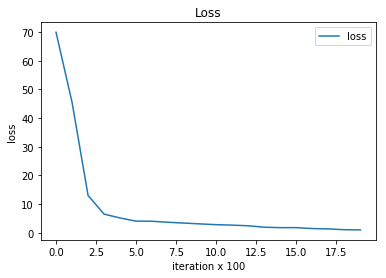

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()  
plt.plot(range(len(model_loss)), model_loss, label='loss')
plt.xlabel('iteration x 100')
plt.ylabel('loss')
plt.title("Loss")
plt.legend()
plt.show()

In [15]:
Center_mat = np.load('Center_mat.npy')

In [45]:
# ۲۲۶  خردمند
# ۱۵۹۹  گلاب
# ۲۰۳۹ سیستان
# ۱۰۳ رستم
# ۶۱ ایران

iran = Center_mat[:,61]
rostam = Center_mat[:,103]
kheradmand = Center_mat[:,226]
golab = Center_mat[:,1599]
sistan = Center_mat[:,2039]


ir = list()
ros = list()
khrd = list()
gol = list()
sis = list()

for i in range(len(words)):
    
    c1 = np.corrcoef(iran,Center_mat[:,i])
    c2 = np.corrcoef(rostam,Center_mat[:,i])
    c3 = np.corrcoef(kheradmand,Center_mat[:,i])
    c4 = np.corrcoef(golab,Center_mat[:,i])
    c5 = np.corrcoef(sistan,Center_mat[:,i])
    
    ir = ir + [c1[0,1]] 
    ros = ros + [c2[0,1]]
    khrd = khrd + [c3[0,1]]
    gol = gol + [c4[0,1]]
    sis = sis + [c5[0,1]]
    


In [64]:
idx1 = (-np.array(ir)).argsort()[:6]
idx2 = (-np.array(ros)).argsort()[:6]
idx3 = (-np.array(khrd)).argsort()[:6]
idx4 = (-np.array(gol)).argsort()[:6]
idx5 = (-np.array(sis)).argsort()[:6]


In [65]:
print(words[idx1])
print()
print(words[idx2])
print()
print(words[idx3])
print()
print(words[idx4])
print()
print(words[idx5])
print()

['ایران' 'دورویند' 'نوشتست' 'سربگاشت' 'سیاهست' 'برداشت']

['رستم' 'وکارکرد' 'سالارنو' 'نجستم' 'کردگارمکان' 'پرستیز']

['خردمند' 'فروزان' 'سرسوی' 'شتابنده' 'سپردندشان' 'مشکن']

['گلاب' 'نیکوگمان' 'خونیان' 'بخشیدی' 'اژیرتر' 'بکوبند']

['سیستان' 'هممی' 'افسرست' 'خوانهای' 'کاسپان' 'سهبد']

